In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import brier_score_loss, roc_auc_score, accuracy_score, f1_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import shap
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [16]:
# Load dataset (replace path if needed)
df = pd.read_csv("diabetic_data.csv")

# Basic cleaning
df.replace('?', np.nan, inplace=True)
df.drop(columns=["encounter_id", "patient_nbr"], errors="ignore", inplace=True)

# Target setup: 1 = readmitted within 30 days, 0 = otherwise
df["readmitted"] = df["readmitted"].replace({"<30": 1, ">30": 0, "NO": 0}).astype(int)

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (101766, 48)


,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No,No,0
1,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,...,No,Up,No,No,No,No,No,Ch,Yes,0
2,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,...,No,No,No,No,No,No,No,No,Yes,0
3,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,...,No,Up,No,No,No,No,No,Ch,Yes,0
4,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,...,No,Steady,No,No,No,No,No,Ch,Yes,0


In [17]:
DATA_PATH = "diabetic_data.csv"    
TARGET_COL = "readmitted"          
TIME_COL = None                   
ID_COL = "encounter_id"          
num_cols = df.select_dtypes(include=["number"]).columns.drop(TARGET_COL, errors="ignore").tolist()
cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Numeric columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))

Numeric columns: 11
Categorical columns: 36


In [18]:
#  TIME-BASED DATA SPLIT TO PREVENT LEAKAGE 

print("Implementing time-based split to prevent data leakage...")

# Check if we have temporal information
print("Dataset columns:", df.columns.tolist())


# Create temporal split (80% early data for training, 20% recent data for testing)
split_point = int(0.8 * len(df))


# Common in healthcare: assume data is roughly chronological by encounter
df_sorted = df.reset_index(drop=True)
print("Using dataset order as proxy for temporal sequence")

# Time-based split
train_df = df_sorted.iloc[:split_point]
test_df = df_sorted.iloc[split_point:]

print(f"Training set: {len(train_df)} samples (earlier period)")
print(f"Test set: {len(test_df)} samples (later period)")
print(f"Training period: First {split_point} encounters")
print(f"Test period: Last {len(df) - split_point} encounters")

# Prepare features and targets
X_train_time = train_df.drop(columns=["readmitted"])
y_train_time = train_df["readmitted"]
X_test_time = test_df.drop(columns=["readmitted"]) 
y_test_time = test_df["readmitted"]

print(f"\nClass distribution in training: {y_train_time.value_counts().to_dict()}")
print(f"Class distribution in test: {y_test_time.value_counts().to_dict()}")

Implementing time-based split to prevent data leakage...
Dataset columns: ['race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']
Using dataset order as proxy for temporal sequence
Training set: 81412 samples (earlier period)
Test set: 20354 samples (later period)
Trai

In [19]:
X = df.drop(columns=["readmitted"])
y = df["readmitted"]

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

# Numeric pipeline with KNNImputer
num_pipe = Pipeline([
    ("imp", KNNImputer(n_neighbors=5)),
    ("scaler", StandardScaler())
])

# Categorical pipeline
cat_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("enc", OneHotEncoder(handle_unknown="ignore"))
])

# Combine both
preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

# Use the time-based split instead of random split
X_train, X_test, y_train, y_test = X_train_time, X_test_time, y_train_time, y_test_time

print("Using time-based split to prevent data leakage")
print(f"Training shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Using time-based split to prevent data leakage
Training shape: (81412, 47)
Test shape: (20354, 47)


In [20]:
# Fast Feature Selection using SelectFromModel (SFM)
# Fit RF on preprocessed data 
rf_sfm = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)

# Select top features (median importance)
sfm = SelectFromModel(rf_sfm, threshold="median")
X_train_sel = sfm.fit_transform(X_train_pre, y_train)
X_test_sel = sfm.transform(X_test_pre)

# Get selected feature names
ohe = preprocessor.named_transformers_["cat"].named_steps["enc"]
cat_names = ohe.get_feature_names_out(cat_cols).tolist()
feature_names = list(num_cols) + cat_names  
selected_features = [f for f, s in zip(feature_names, sfm.get_support()) if s]
# print(selected_features)
# print(len(selected_features), "features selected out of", len(feature_names))
print(f"Selected {len(selected_features)} features using SFM")

Selected 1179 features using SFM


In [21]:
# Handle Class Imbalance
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate class weights
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(y_train), 
    y=y_train
)

# Convert to dictionary for Random Forest
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"Class distribution - 0: {sum(y_train==0)}, 1: {sum(y_train==1)}")
print(f"Class weights: {class_weight_dict}")
print(f"XGBoost scale_pos_weight: {len(y_train[y_train==0]) / len(y_train[y_train==1]):.2f}")

Class distribution - 0: 72222, 1: 9190
Class weights: {0: np.float64(0.5636232726869929), 1: np.float64(4.429379760609358)}
XGBoost scale_pos_weight: 7.86


In [22]:

rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1,class_weight=class_weight_dict )
rf_pipe = Pipeline([("pre", preprocessor), ("clf", rf_model)])
rf_pipe.fit(X_train, y_train)

rf_probs = rf_pipe.predict_proba(X_test)[:, 1]
rf_preds = (rf_probs > 0.5).astype(int)

rf_auc = roc_auc_score(y_test, rf_probs)
rf_acc = accuracy_score(y_test, rf_preds)
rf_f1 = f1_score(y_test, rf_preds)
rf_brier = brier_score_loss(y_test, rf_probs)

print(f"Random Forest → AUC: {rf_auc:.3f}, ACC: {rf_acc:.3f}, F1: {rf_f1:.3f}, Brier: {rf_brier:.3f}")


Random Forest → AUC: 0.626, ACC: 0.894, F1: 0.001, Brier: 0.093


In [23]:
# Calculate the imbalance ratio
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", n_estimators=50, random_state=42, scale_pos_weight=scale_pos_weight)
xgb_pipe = Pipeline([("pre", preprocessor), ("clf", xgb_model)])
xgb_pipe.fit(X_train, y_train)

xgb_probs = xgb_pipe.predict_proba(X_test)[:, 1]
xgb_preds = (xgb_probs > 0.5).astype(int)

xgb_auc = roc_auc_score(y_test, xgb_probs)
xgb_acc = accuracy_score(y_test, xgb_preds)
xgb_f1 = f1_score(y_test, xgb_preds)
xgb_brier = brier_score_loss(y_test, xgb_probs)

print(f"XGBoost → AUC: {xgb_auc:.3f}, ACC: {xgb_acc:.3f}, F1: {xgb_f1:.3f}, Brier: {xgb_brier:.3f}")

XGBoost → AUC: 0.661, ACC: 0.648, F1: 0.257, Brier: 0.219


In [24]:
svm_model = SVC(probability=True, kernel="rbf", class_weight="balanced", random_state=42)
svm_pipe = Pipeline([("pre", preprocessor), ("clf", svm_model)])

# Train on smaller subset for performance
svm_pipe.fit(X_train[:5000], y_train[:5000])

svm_probs = svm_pipe.predict_proba(X_test)[:, 1]
svm_preds = (svm_probs > 0.5).astype(int)
y_svm = y_test

svm_auc = roc_auc_score(y_svm, svm_probs)
svm_acc = accuracy_score(y_svm, svm_preds)
svm_f1 = f1_score(y_svm, svm_preds)
svm_brier = brier_score_loss(y_svm, svm_probs)

print(f"SVM → AUC: {svm_auc:.3f}, ACC: {svm_acc:.3f}, F1: {svm_f1:.3f}, Brier: {svm_brier:.3f}")


SVM → AUC: 0.565, ACC: 0.894, F1: 0.000, Brier: 0.095


In [25]:
import pandas as pd


results_df = pd.DataFrame([
    {"Model": "Random Forest", "AUC": rf_auc, "ACC": rf_acc, "F1": rf_f1, "Brier": rf_brier},
    {"Model": "XGBoost", "AUC": xgb_auc, "ACC": xgb_acc, "F1": xgb_f1, "Brier": xgb_brier},
    {"Model": "SVM (subset)", "AUC": svm_auc, "ACC": svm_acc, "F1": svm_f1, "Brier": svm_brier},
])

# Sort by AUC (best first)
results_df = results_df.sort_values(by="AUC", ascending=False).reset_index(drop=True)

# Table
print(" Model Performance Comparison:")
display(results_df)


 Model Performance Comparison:


,Model,AUC,ACC,F1,Brier
0,XGBoost,0.661017,0.648276,0.256825,0.218719
1,Random Forest,0.625869,0.893534,0.000922,0.093179
2,SVM (subset),0.564584,0.893534,0.000000,0.095169


In [26]:
from sklearn.calibration import CalibratedClassifierCV

X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_cal = CalibratedClassifierCV(rf_model, method="isotonic", cv=5)
rf_cal.fit(X_train_pre, y_train)
rf_probs_cal = rf_cal.predict_proba(X_test_pre)[:, 1]

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_cal = CalibratedClassifierCV(xgb_model, method="isotonic", cv=5)
xgb_cal.fit(X_train_pre, y_train)
xgb_probs_cal = xgb_cal.predict_proba(X_test_pre)[:, 1]

svm_model = SVC(probability=True, kernel="rbf", class_weight="balanced", random_state=42)
svm_cal = CalibratedClassifierCV(svm_model, method="isotonic", cv=3)
svm_cal.fit(X_train_pre[:5000], y_train[:5000])
svm_probs_cal = svm_cal.predict_proba(X_test_pre)[:, 1]


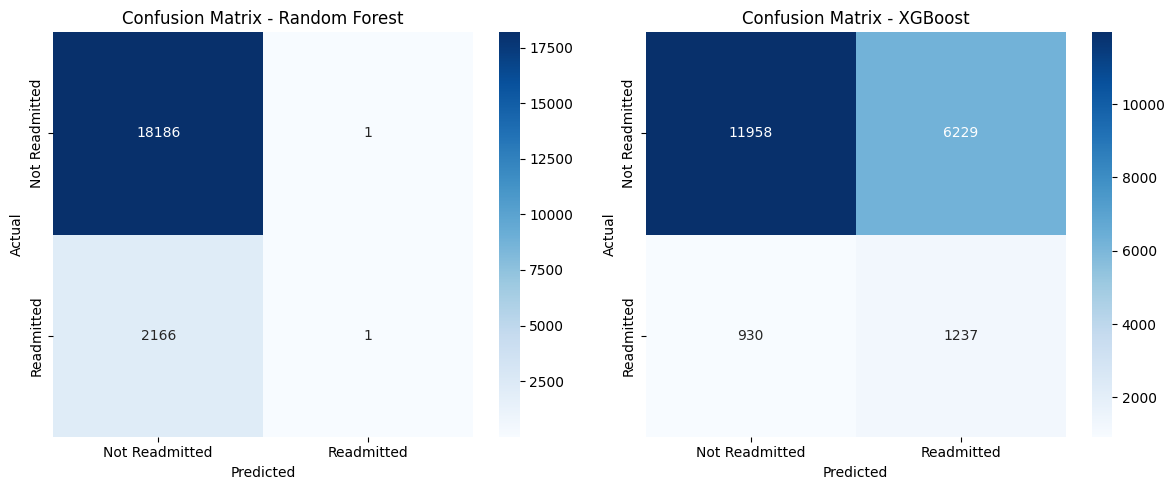

RANDOM FOREST CLASSIFICATION REPORT
                precision    recall  f1-score   support

Not Readmitted       0.89      1.00      0.94     18187
    Readmitted       0.50      0.00      0.00      2167

      accuracy                           0.89     20354
     macro avg       0.70      0.50      0.47     20354
  weighted avg       0.85      0.89      0.84     20354

XGBOOST CLASSIFICATION REPORT
                precision    recall  f1-score   support

Not Readmitted       0.93      0.66      0.77     18187
    Readmitted       0.17      0.57      0.26      2167

      accuracy                           0.65     20354
     macro avg       0.55      0.61      0.51     20354
  weighted avg       0.85      0.65      0.72     20354


CONFUSION MATRICES (Numerical)

Random Forest:
[[18186     1]
 [ 2166     1]]

XGBoost:
[[11958  6229]
 [  930  1237]]


In [48]:
# Add a new cell here with the confusion matrix code
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'Confusion Matrix - {model_name}')
    ax.xaxis.set_ticklabels(['Not Readmitted', 'Readmitted'])
    ax.yaxis.set_ticklabels(['Not Readmitted', 'Readmitted'])

# Create predictions for both models
rf_preds = (rf_probs > 0.5).astype(int)
xgb_preds = (xgb_probs > 0.5).astype(int)

# Create subplots for 2 models
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot confusion matrices
plot_confusion_matrix(y_test, rf_preds, 'Random Forest', axes[0])
plot_confusion_matrix(y_test, xgb_preds, 'XGBoost', axes[1])

plt.tight_layout()
plt.show()

# Print detailed classification reports
print("="*50)
print("RANDOM FOREST CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, rf_preds, target_names=['Not Readmitted', 'Readmitted']))

print("="*50)
print("XGBOOST CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, xgb_preds, target_names=['Not Readmitted', 'Readmitted']))

# Also show confusion matrices in numerical form
print("\n" + "="*50)
print("CONFUSION MATRICES (Numerical)")
print("="*50)

print("\nRandom Forest:")
print(confusion_matrix(y_test, rf_preds))

print("\nXGBoost:")
print(confusion_matrix(y_test, xgb_preds))

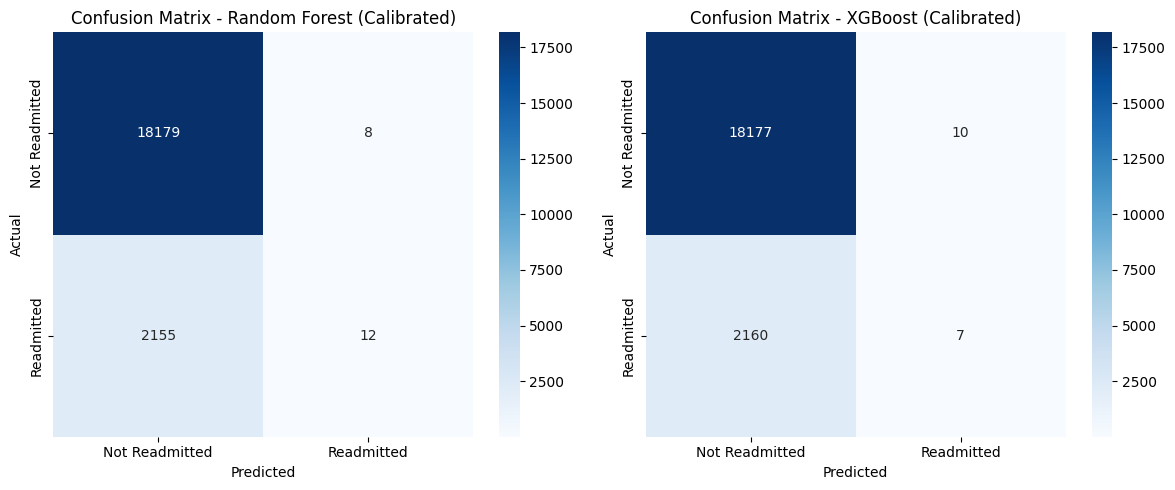

In [49]:
# For calibrated models
rf_preds_cal = (rf_probs_cal > 0.5).astype(int)
xgb_preds_cal = (xgb_probs_cal > 0.5).astype(int)

# Create subplots for calibrated models
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot confusion matrices for calibrated models
plot_confusion_matrix(y_test, rf_preds_cal, 'Random Forest (Calibrated)', axes[0])
plot_confusion_matrix(y_test, xgb_preds_cal, 'XGBoost (Calibrated)', axes[1])

plt.tight_layout()
plt.show()

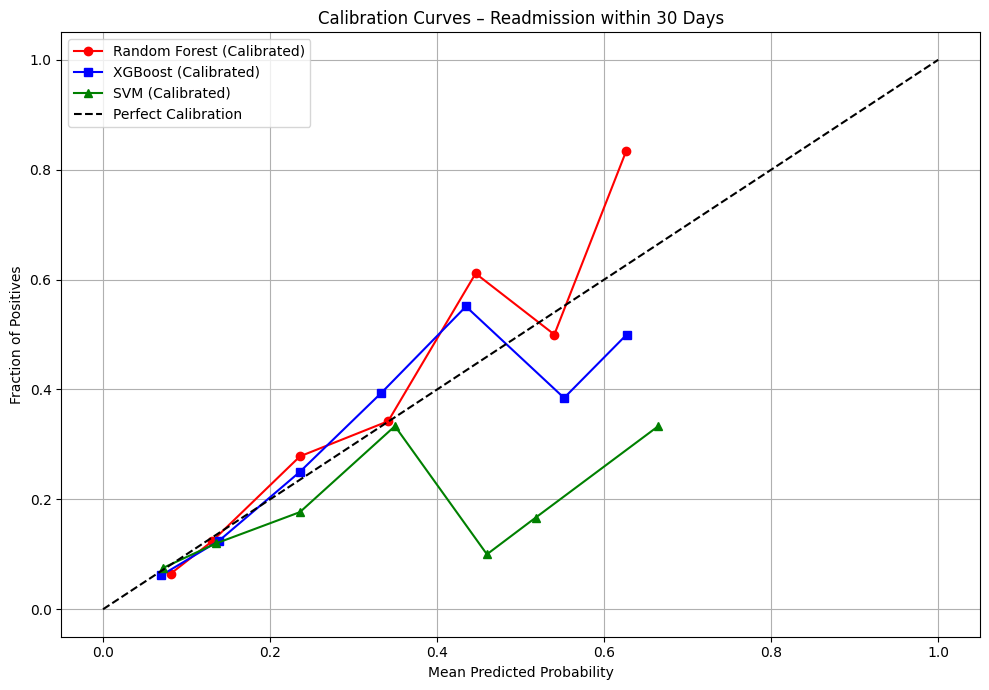

In [27]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

# Random Forest (Calibrated)
rf_true_cal, rf_pred_cal = calibration_curve(y_test, rf_probs_cal, n_bins=10)
plt.plot(rf_pred_cal, rf_true_cal, marker='o', linestyle='-', color='red', label='Random Forest (Calibrated)')

# XGBoost (Calibrated)
xgb_true_cal, xgb_pred_cal = calibration_curve(y_test, xgb_probs_cal, n_bins=10)
plt.plot(xgb_pred_cal, xgb_true_cal, marker='s', linestyle='-', color='blue', label='XGBoost (Calibrated)')

# SVM (Calibrated)
svm_true_cal, svm_pred_cal = calibration_curve(y_svm, svm_probs_cal, n_bins=10)
plt.plot(svm_pred_cal, svm_true_cal, marker='^', linestyle='-', color='green', label='SVM (Calibrated)')

# Perfect calibration line
plt.plot([0,1],[0,1],'k--', label='Perfect Calibration')

plt.title("Calibration Curves – Readmission within 30 Days")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
import numpy as np
import matplotlib.pyplot as plt

def decision_curve_analysis(y_true, y_prob, thresholds=np.linspace(0.01, 0.99, 100)):
    net_benefit = []
    for t in thresholds:
        preds = (y_prob >= t).astype(int)
        TP = np.sum((preds == 1) & (y_true == 1))
        FP = np.sum((preds == 1) & (y_true == 0))
        N = len(y_true)
        nb = (TP / N) - (FP / N) * (t / (1 - t))
        net_benefit.append(nb)
    return thresholds, net_benefit


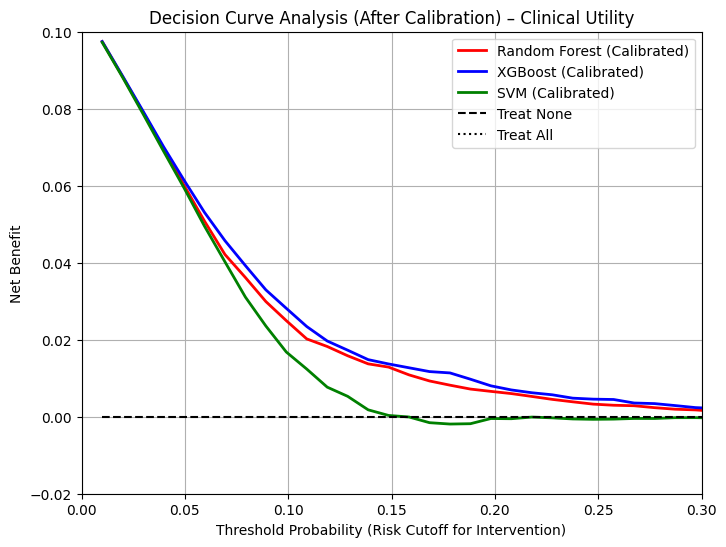

In [29]:
# Compute calibrated DCA
thresholds, rf_nb = decision_curve_analysis(y_test, rf_probs_cal)
_, xgb_nb = decision_curve_analysis(y_test, xgb_probs_cal)
_, svm_nb = decision_curve_analysis(y_test, svm_probs_cal)

plt.figure(figsize=(8,6))
plt.plot(thresholds, rf_nb, 'r-', lw=2, label="Random Forest (Calibrated)")
plt.plot(thresholds, xgb_nb, 'b-', lw=2, label="XGBoost (Calibrated)")
plt.plot(thresholds, svm_nb, 'g-', lw=2, label="SVM (Calibrated)")
plt.plot(thresholds, [0]*len(thresholds), 'k--', label="Treat None")
plt.plot(thresholds, [1 - t/(1-t) for t in thresholds], 'k:', label="Treat All")

plt.xlim(0, 0.3)
plt.ylim(-0.02, 0.1)
plt.xlabel("Threshold Probability (Risk Cutoff for Intervention)")
plt.ylabel("Net Benefit")
plt.title("Decision Curve Analysis (After Calibration) – Clinical Utility")
plt.legend()
plt.grid(True)
plt.show()


In [30]:
from sklearn.metrics import brier_score_loss

print("Brier Scores (lower is better):")
print(f"Random Forest (Calibrated): {brier_score_loss(y_test, rf_probs_cal):.4f}")
print(f"XGBoost (Calibrated): {brier_score_loss(y_test, xgb_probs_cal):.4f}")
print(f"SVM (Calibrated): {brier_score_loss(y_test, svm_probs_cal):.4f}")


Brier Scores (lower is better):
Random Forest (Calibrated): 0.0916
XGBoost (Calibrated): 0.0909
SVM (Calibrated): 0.0947


100%|===================| 81131/81412 [03:33<00:00]        

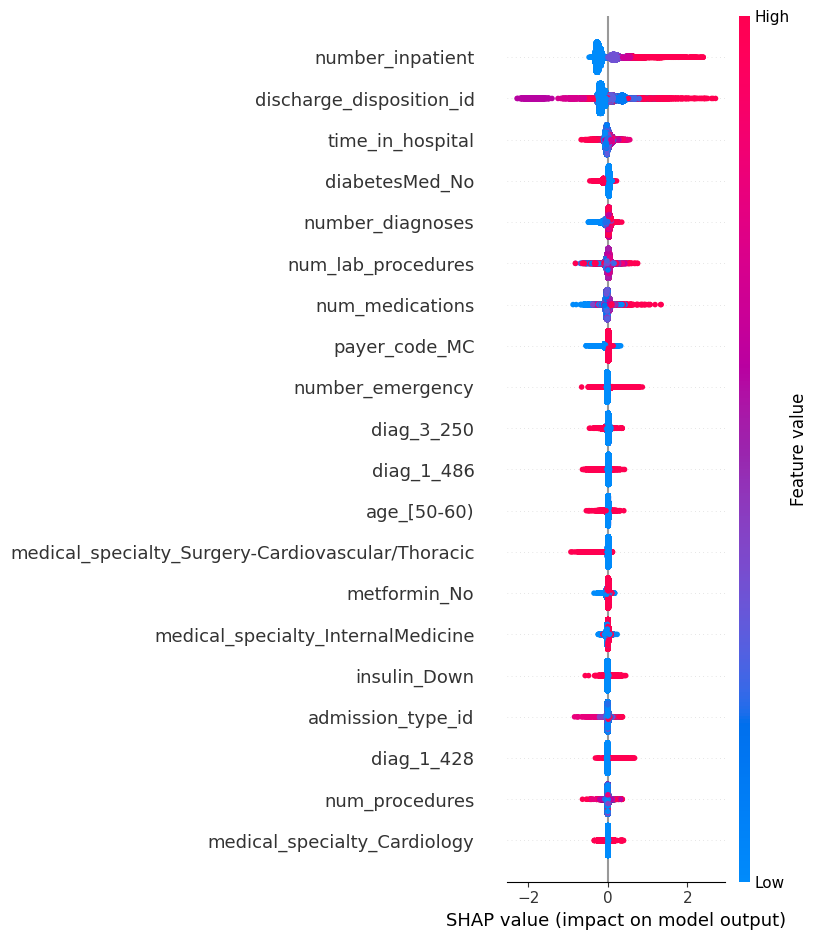

In [ ]:
import shap
import pandas as pd
from xgboost import XGBClassifier

# Train XGBoost on preprocessed data
xgb_final = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

# Transform training data (convert sparse to dense)
X_train_pre = preprocessor.fit_transform(X_train)

# If sparse matrix → convert to dense
if not isinstance(X_train_pre, pd.DataFrame) and hasattr(X_train_pre, "toarray"):
    X_train_pre = X_train_pre.toarray()

# Fit the model
xgb_final.fit(X_train_pre, y_train)

# Convert preprocessed array to DataFrame
encoded_feature_names = list(num_cols) + list(ohe.get_feature_names_out(cat_cols))
X_train_pre_df = pd.DataFrame(X_train_pre, columns=encoded_feature_names)

# Generate SHAP values with proper feature mapping
explainer = shap.Explainer(xgb_final, X_train_pre_df)
shap_values = explainer(X_train_pre_df)

# Plot SHAP summary (colored)
shap.summary_plot(shap_values, X_train_pre_df, show=True)


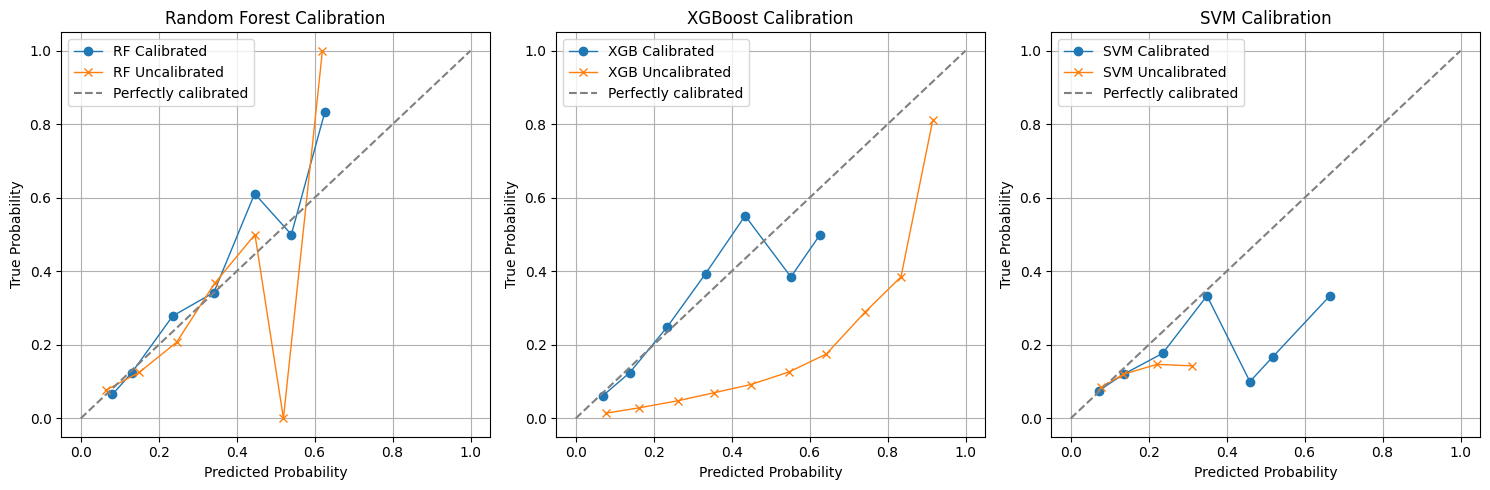

In [38]:
# Generate Calibration Plots
plt.figure(figsize=(15, 5))

# Plot 1: Random Forest Calibration
plt.subplot(1, 3, 1)
rf_prob_true, rf_prob_pred = calibration_curve(y_test, rf_probs_cal, n_bins=10)
plt.plot(rf_prob_pred, rf_prob_true, marker='o', linewidth=1, label='RF Calibrated')
rf_prob_true_uncal, rf_prob_pred_uncal = calibration_curve(y_test, rf_probs, n_bins=10)
plt.plot(rf_prob_pred_uncal, rf_prob_true_uncal, marker='x', linewidth=1, label='RF Uncalibrated')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Random Forest Calibration')
plt.legend()
plt.grid(True)

# Plot 2: XGBoost Calibration
plt.subplot(1, 3, 2)
xgb_prob_true, xgb_prob_pred = calibration_curve(y_test, xgb_probs_cal, n_bins=10)
plt.plot(xgb_prob_pred, xgb_prob_true, marker='o', linewidth=1, label='XGB Calibrated')
xgb_prob_true_uncal, xgb_prob_pred_uncal = calibration_curve(y_test, xgb_probs, n_bins=10)
plt.plot(xgb_prob_pred_uncal, xgb_prob_true_uncal, marker='x', linewidth=1, label='XGB Uncalibrated')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('XGBoost Calibration')
plt.legend()
plt.grid(True)

# Plot 3: SVM Calibration
plt.subplot(1, 3, 3)
svm_prob_true, svm_prob_pred = calibration_curve(y_test, svm_probs_cal, n_bins=10)
plt.plot(svm_prob_pred, svm_prob_true, marker='o', linewidth=1, label='SVM Calibrated')
svm_prob_true_uncal, svm_prob_pred_uncal = calibration_curve(y_test, svm_probs, n_bins=10)
plt.plot(svm_prob_pred_uncal, svm_prob_true_uncal, marker='x', linewidth=1, label='SVM Uncalibrated')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('SVM Calibration')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [39]:
import shap
import numpy as np
import pandas as pd

# Sample the training data
sample_size = 5000  
if X_train_pre.shape[0] > sample_size:
    sample_idx = np.random.choice(X_train_pre.shape[0], size=sample_size, replace=False)
    X_sample = X_train_pre[sample_idx]
else:
    X_sample = X_train_pre

# TreeExplainer for XGBoost
explainer = shap.TreeExplainer(xgb_final)
shap_values = explainer.shap_values(X_sample) 

# Compute mean absolute SHAP values
shap_abs = np.abs(shap_values).mean(axis=0)
shap_mean = shap_values.mean(axis=0)  # positive = ↑ readmission

# Select Top 15 features
top_idx = np.argsort(shap_abs)[::-1][:15]
top_features = [feature_names[i] for i in top_idx]
top_importances = shap_abs[top_idx]
top_direction = ["↑" if shap_mean[i] > 0 else "↓" for i in top_idx]

# Create DataFrame
top_shap_df = pd.DataFrame({
    "Rank": range(1, 16),
    "Feature": top_features,
    "Impact (Mean |SHAP|)": np.round(top_importances, 4),
    "Readmission Effect": top_direction
})

print("\nTop 15 Predictors Influencing 30-Day Readmission:\n")
print(top_shap_df.to_string(index=False))



Top 15 Predictors Influencing 30-Day Readmission:

 Rank                            Feature  Impact (Mean |SHAP|) Readmission Effect
    1                   number_inpatient                0.3069                  ↓
    2           discharge_disposition_id                0.2290                  ↓
    3                     diabetesMed_No                0.0515                  ↓
    4                   time_in_hospital                0.0490                  ↓
    5                   number_diagnoses                0.0460                  ↑
    6                 num_lab_procedures                0.0399                  ↓
    7                    num_medications                0.0382                  ↓
    8                      payer_code_MC                0.0303                  ↓
    9                   number_emergency                0.0303                  ↓
   10                        age_[50-60)                0.0233                  ↓
   11                         diag_3_250      

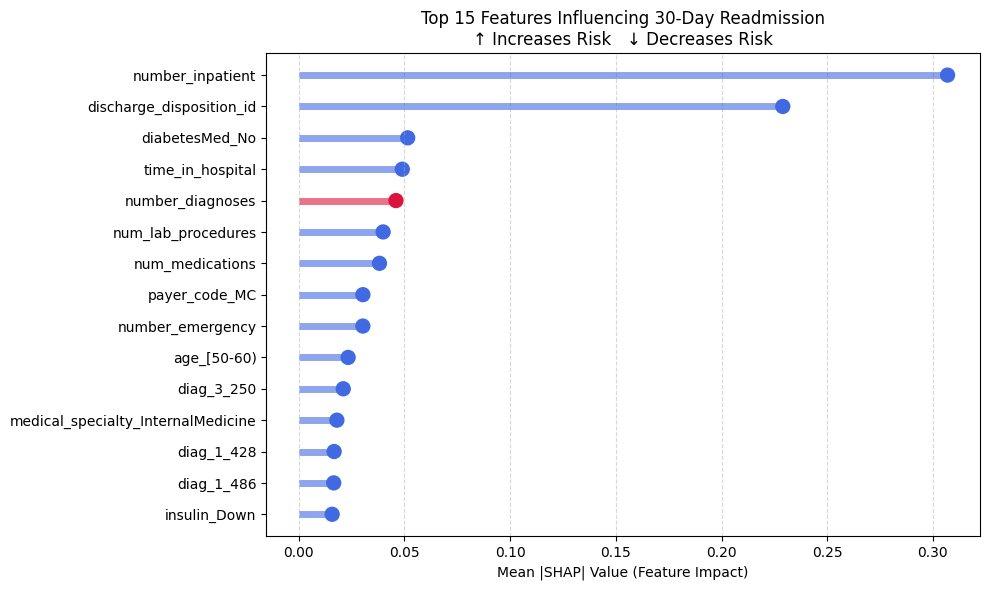

In [40]:
import matplotlib.pyplot as plt
import numpy as np

features = top_features[::-1]
importances = top_importances[::-1]
directions = top_direction[::-1]
colors = ["crimson" if d == "↑" else "royalblue" for d in directions]

plt.figure(figsize=(10, 6))
plt.hlines(y=features, xmin=0, xmax=importances, color=colors, alpha=0.6, linewidth=5)
plt.scatter(importances, features, color=colors, s=100)
plt.xlabel("Mean |SHAP| Value (Feature Impact)")
plt.title("Top 15 Features Influencing 30-Day Readmission\n↑ Increases Risk   ↓ Decreases Risk")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [41]:
import pandas as pd
from sklearn.metrics import brier_score_loss

# Compute Brier scores on calibrated probabilities
rf_brier_cal = brier_score_loss(y_test, rf_probs_cal)
xgb_brier_cal = brier_score_loss(y_test, xgb_probs_cal)
svm_brier_cal = brier_score_loss(y_svm, svm_probs_cal)

# Create summary DataFrame
summary_df = pd.DataFrame([
    {"Model": "Random Forest", "AUC": rf_auc, "Brier Score (Calibrated)": rf_brier_cal},
    {"Model": "XGBoost",      "AUC": xgb_auc, "Brier Score (Calibrated)": xgb_brier_cal},
    {"Model": "SVM",          "AUC": svm_auc, "Brier Score (Calibrated)": svm_brier_cal}
])

# Sort by Brier Score (lower is better)
summary_df = summary_df.sort_values(by="Brier Score (Calibrated)", ascending=True).reset_index(drop=True)

print("Model Performance Summary (AUC & Calibrated Brier Score):")
display(summary_df)


Model Performance Summary (AUC & Calibrated Brier Score):


,Model,AUC,Brier Score (Calibrated)
0,XGBoost,0.661017,0.090860
1,Random Forest,0.625869,0.091627
2,SVM,0.564584,0.094724
